# How to use

In [1]:
import torch
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from ptimz.utils.viz import plot_semseg

C:\Users\27142\Anaconda3\envs\kaifa\lib\site-packages\mmcv\cnn\bricks\transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


## Load a fetal brain T2-weighted image
Please download [Image](https://github.com/songphilips/ptimz/releases/tag/v0.0.1-hrnet/cyclegan_demo_data.zip) to your local path.
[checkpoint file](https://github.com/songphilips/ptimz/releases/tag/v0.0.1-hrnet/cyclegan_net_G_A.pth.tar)

In [2]:
import ptimz

Or find models with key words

In [3]:
print(ptimz.list_models("*cyclegan*"))


['cyclegan_2d']


Find available pretrained weights by model name

In [4]:
print(ptimz.list_pretrained_names("cyclegan_2d"))

['lung_ct']


construct cyclegan and load the pretrained weight

In [5]:
model = ptimz.create_model("cyclegan_2d", pretrained='lung_ct')


In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import pydicom

def sitk_read(patient_path):
    reader = sitk.ImageSeriesReader()
    slice_names = reader.GetGDCMSeriesFileNames(patient_path)
    # print(slice_names)
    reader.SetFileNames(slice_names)
    image = reader.Execute()
    origin = image.GetOrigin()
    spacing = image.GetSpacing()
    # keys = image.GetMetaDataKeys()
    image_array = sitk.GetArrayFromImage(image)
    return image_array, origin, spacing


def read_dcm(patient_path):
    slices_path = os.listdir(patient_path)
    slices_npy = []
    img_posi_list = []
    for slice in slices_path:
        if slice.startswith("I"):
            slice_dicom = pydicom.read_file(os.path.join(patient_path, slice))
            # print('slice_dicom', slice_dicom)
            slice_npy = slice_dicom.pixel_array
            slices_npy.append(slice_npy)
            img_posi_list.append(slice_dicom.ImagePositionPatient[-1])
    slices_npy_sort = sort_posi(slices_npy, img_posi_list)
    slices_npy_sort = np.array(slices_npy_sort)
    # plt.imshow(slices_npy_sort[:, :, 250], cmap='gray')
    # plt.show()
    return slices_npy_sort


def sort_posi(img_npy_list, img_posi_list):
    sorted_id = sorted(range(len(img_posi_list)), key=lambda k: img_posi_list[k], reverse=True)
    img_npy_list_sort = []
    for q in range(len(sorted_id)):
        img_npy_list_sort.append(img_npy_list[sorted_id[q]])
    img_npy_list_sort = np.array(img_npy_list_sort)
    # print('train_patient_path_sort', train_patient_path_sort)
    # print('img_npy_list_sort.shape', img_npy_list_sort.shape)
    return img_npy_list_sort


def hist_plot_crop_norm(data):
    # plt.imshow(data[100, :, :], cmap='gray')
    # plt.show()
    data_reshape = data.reshape(-1)
    # fig, axes = plt.subplots()
    # axes.hist(data_reshape, range=(0, 4000), facecolor='g')
    # axes.set_ylim([0, 60000000])
    # plt.savefig(path_before)
    # plt.close()

    # crop
    threshold = 1500
    # data[data < threshold] = 0
    # plt.imshow(data[100, :, :], cmap='gray')
    # plt.show()
    data[data > threshold] = threshold
    # plt.imshow(data[100, :, :], cmap='gray')
    # plt.show()
    data_reshape = data.reshape(-1)
    # fig, axes = plt.subplots()
    # axes.hist(data_reshape, range=(0, 1500), facecolor='r')
    # axes.set_ylim([0, 60000000])
    # plt.savefig(path_after)
    # plt.close()

    # normalization
    data = data/threshold
    # print('mean-std', np.mean(data), np.std(data))
    # print('min-max', np.min(data), np.max(data))
    return data


def pre_processing(path):
    # print(patient)
    # patient_name = patient.split(('\\'))[-1]
    # print('patient_name', patient_name)
    # _, origin, spacing = sitk_read(patient)
    patient_npy = read_dcm(path)
    # print(patient_npy.shape)
    patient_npy_crop_norm = hist_plot_crop_norm(patient_npy)

    return patient_npy_crop_norm


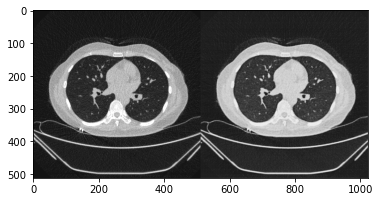

In [7]:
img_path = './cyclegan_demo_data/patient1' # Modify the path to your local data folder
save_path = r'./output'

slices = pre_processing(img_path)
idx_num = 150
my_input = slices[150, :, :]

with torch.no_grad():
    my_input = np.expand_dims(my_input, axis=0)
    my_input = np.expand_dims(my_input, axis=0)
    # print('my_input', my_input.shape)
    my_input = torch.from_numpy(my_input).type(torch.FloatTensor)
    my_output = model(my_input)
    plt.imshow(np.concatenate((my_input[0, 0, :, :], my_output[0, 0, :, :]), axis=1), cmap='gray')
    plt.show()
    my_output = sitk.GetImageFromArray(my_output[0, 0, :, :])

    sitk.WriteImage(my_output, os.path.join(save_path, str(idx_num) + '.nii.gz'))